# U1T2 - Co-authorship 

## Overview

This notebook uses data obtained from [Scopus](http://scopus.com) database to build and analyze a co-authorship network for publications in the area of engineering at [UFRN](http://ufrn.br).

## Browse
* [Data](#the-data)
* [Network](#the-network)
    * [Ranking](#ranking)
    * [Subgraphing](#subgraphing)
    * [Stats](#stats)
    * [Visualizations](#visualizations)
    * [Extras](#extras)

## The Data

The data studied consists of info about 3,666 publications by researchers at UFRN in the sub-area of engineering. For each publication, there are information about the authors, title, year of publication, number of citations, keywords and funding.

In [53]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [54]:
# Creates a dataframe from the csv file
df = pd.read_csv('assets/ufrn_engineering_data.csv')

# Creates a graph
G = nx.Graph()

# Defines the maximum number of 'top' nodes to show on visualizations
TOP_NODES = 3

In [55]:
# Extracts the list of authors from the dataframe
authors_list = df['Author full names'].str.split('; ')

# Cleans the dataframe from unused columns
df.drop(columns=['Author full names', 'Funding Details', 'Link', 'Index Keywords'], inplace=True)

# Creates a new column with the number of authors in each paper
df['Author(s) ID'] = df['Author(s) ID'].str.split('; ')
df['# of Authors'] = df['Author(s) ID'].apply(len)

# Reorders the columns
df = df[['Title', 'Authors', 'Author(s) ID', 'Year', 'Cited by', '# of Authors']]

In [56]:
# Transforms all authors into nodes having attributes 'name', 'citations' and 'publications'
nodes = {}
for authors in authors_list:
    for author in authors:
        author = author.split(' (')
        author[0] = author[0].split(', ')
        # Puts author names in the format 'Firstname Lastname' if possible
        if len(author[0]) > 1:
            reordered_name = author[0][1] + ' ' + author[0][0]
        else:
            reordered_name = author[0][0]
        nodes[author[1][:-1]] = {'name' : reordered_name, 'citations': 0, 'publications': 0}

In [57]:
# Add all authors to the graph with the attributes defined above
G.add_nodes_from(nodes.items())

""" Extract author information from a publication and add it to the graph as an edge and as node attributes"""
def add_edges_from_publication(publication):
    for author in publication['Author(s) ID']:
        G.nodes[author]["citations"] += int(publication['Cited by'])
        G.nodes[author]["publications"] += 1
    
    # Add an edge between all pairs of authors in the publication
    for pair in combinations(publication['Author(s) ID'], 2):
        if pair in G.edges:
            G[pair[0]][pair[1]]["year"].add(publication['Year'])
        else:
            G.add_edge(pair[0], pair[1], year = {publication['Year']})


In [58]:
# Apply the function to the dataframe in order to populate the graph
_ = df.apply(func = add_edges_from_publication, axis=1)

## The Network

From the steps taken previously we've built a co-authorship network that enables us to think more deeply about the dynamics of the academic relationships. For example, we can rank the authors by number of citations, publications or overall connections, we can see how dense the graph is and by extension how 'collaborative' the authors are. We can subgraph based on some criterion and visualize the result.



### Ranking

The authors were ranked by three criteria: number of citations, number of publication and total number of connections.

The `TOP_NODES` variable is used as a filter to present the data in a less overwhelming way. The following code cells are in charge of the task of building a small dataframe with condensed information about the ranking of authors and the subgraph of 'G' with respect to the ranking system established.

In [59]:
# Get the top authors by citations, publications and connections
most_cited = sorted(G.nodes, key=lambda x: G.nodes[x]["citations"], reverse=True)
most_prolific = sorted(G.nodes, key=lambda x: G.nodes[x]["publications"], reverse=True)
most_connected = sorted(G.nodes, key=lambda x: G.degree[x], reverse=True)

# Created a new dataframe with the top authors in each category and their numbers
author_rankings = pd.DataFrame(columns = ['ID', 'Name', 'By citations', '# of citations', 'By publications', '# of publications', 'By connections', '# of connections'])
author_rankings['ID'] = list(set(most_cited[:TOP_NODES]+most_prolific[:TOP_NODES]+most_connected[:TOP_NODES]))

author_rankings[['Name', '# of citations', '# of publications']] = [list(G.nodes[node].values()) for node in author_rankings['ID']]
author_rankings['By citations'] = [most_cited.index(node)+1 for node in author_rankings['ID']]
author_rankings['By publications'] = [most_prolific.index(node)+1 for node in author_rankings['ID']]
author_rankings['By connections'] = [most_connected.index(node)+1 for node in author_rankings['ID']]
author_rankings['# of connections'] = [G.degree[node] for node in author_rankings['ID']]

author_rankings.sort_values(by='Name', inplace=True, ignore_index=True)
author_rankings

ID                         Name  By citations # of citations  \
0   7004474343        Adaildo G. D'assunção             8           1171   
1   7102422753         Andrés Ortiz Salazar            86            345   
2  15520790700   Benjamín Callejas Bedregal             1           2544   
3   6504310831          Bruno Canto Martins           253            169   
4  22333585200                   F.B. Costa             2           2166   
5  55034746100                  H. Bustince             3           1704   
6  23988784400              Isabelle Boisse           123            255   
7   8870015300  Jonay I. González Hernández           229            179   

   By publications # of publications  By connections  # of connections  
0                1               156             536               159  
1                2                90             555               134  
2               15                62             600                88  
3              332                 7               3               346  
4                3                88             585               104  
5               51                27             700                55  
6              331                 7               1               361  
7              278                 8               2               346

### Subgraphing

For the purposes of this assignment, the subgraphing strategy used differs a bit from the one suggested by the professor. Here we are analyzing the data from six perspectives:

* Global;
* Most cited;
* Most prolific;
* Most connected;
* Global in 2020;
* Global in 2024.

The creation of the subgraphs is in the code cell below as well as each one's density.

In [60]:
subgraphs = []
for node_list in [most_cited, most_prolific, most_connected]:
    temp_set = set()
    for node in node_list[:TOP_NODES]:
        temp_set.add(node)
        for neighbor in G.neighbors(node):
            temp_set.add(neighbor)
    subgraphs.append(G.subgraph(temp_set))

# Extract the edges for the temporal subgraphs
edges_in_2020 = [(u,v) for u,v,d in G.edges(data=True) if 2020 in d['year']]
edges_in_2024 = [(u,v) for u,v,d in G.edges(data=True) if 2024 in d['year']]

nodes_in_2020 = list(set([node for edge in edges_in_2020 for node in edge]))
nodes_in_2024 = list(set([node for edge in edges_in_2024 for node in edge]))

subgraphs.append(G.subgraph(nodes_in_2020))
subgraphs.append(G.subgraph(nodes_in_2024))

C, P, K, G20, G24 = subgraphs

global_density = nx.density(G)
c_density = nx.density(C)
p_density = nx.density(P)
k_density = nx.density(K)
g20_density = nx.density(G20)
g24_density = nx.density(G24)

print(f"Global density: {global_density*100:.2f}%")
print(f"Cited density: {c_density*100:.2f}%")
print(f"Prolific density: {p_density*100:.2f}%")
print(f"Connected density: {k_density*100:.2f}%")
print(f"Global 2020 density: {g20_density*100:.2f}%")
print(f"Global 2024 density: {g24_density*100:.2f}%")

Global density: 0.32%
Cited density: 4.21%
Prolific density: 1.94%
Connected density: 46.96%
Global 2020 density: 1.66%
Global 2024 density: 7.42%


### Stats

In this section we discuss the numbers obtained from the analysis of the data in the graph

* Density

We can see from the output of the cell above that the overall density of the graph is quite low, something like `.32%`, but the 'niche' subgraphs are more dense, especially the one focused on the most connected reaching almost 50% of density. We can also see that 2024 even though is not over, shows a much more intricate network that the one from 4 years ago.

* Degree Histogram

There is an interesting observation to be made in regards the distribution of degrees in the data selected. The code cell below shows how degrees are distributed throughout the graph and we can see that there are some outliers and more importantly some unexpected peaks such as the occurrence of hundreds of authors having more than 300 connections.

[10, 203, 557, 827, 1008, 999, 834, 570, 474, 469, 276, 234, 206, 140, 132, 78, 74, 58, 45, 44, 61, 53, 33, 26, 28, 16, 53, 19, 27, 18, 14, 15, 31, 10, 12, 8, 2, 4, 11, 3, 7, 3, 2, 9, 3, 1, 2, 4, 5, 0, 2, 1, 1, 1, 2, 2, 5, 3, 3, 1, 3, 1, 1, 1, 0, 0, 1, 3, 2, 0, 1, 0, 13, 1, 1, 54, 1, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 9, 0, 13, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 6, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 0, 5, 0, 0, 0, 0, 0, 1, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 4, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 12, 6, 0, 1, 0, 0, 0, 0, 1, 6, 1, 0, 0, 0, 2, 25, 0, 0, 2, 1, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 7, 0, 2, 296, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 

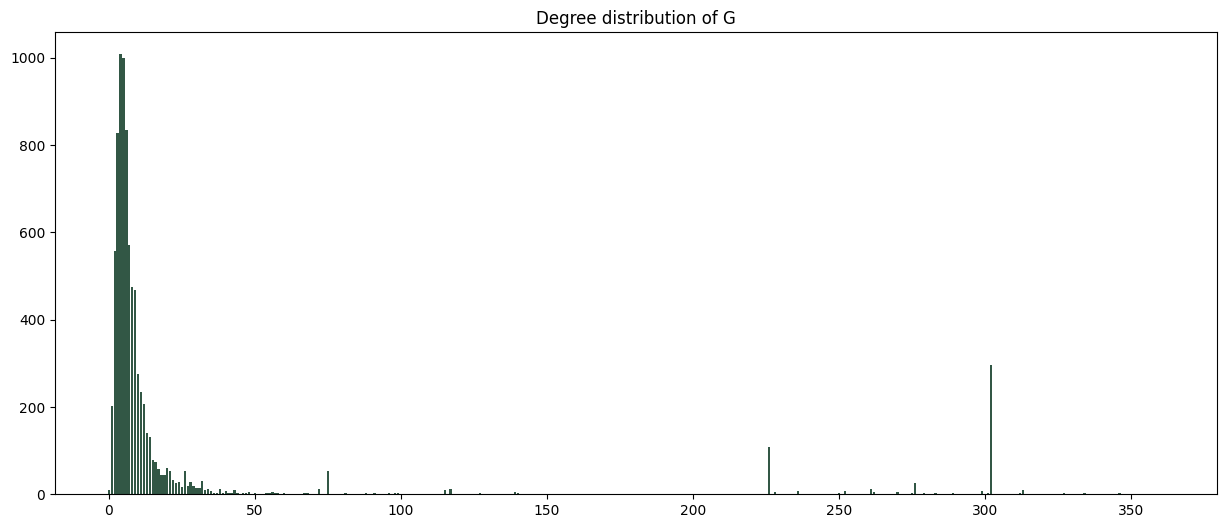

In [61]:
# Create a Series to store the degree histogram of the graph
hist_G = pd.Series(nx.degree_histogram(G))
print(nx.degree_histogram(G))

print(f'The node with most edges has {len(hist_G)} edges')
print(f'The most common number of edges is {hist_G.idxmax()} and {hist_G.max()} nodes have this number of edges')

plt.figure(num='Hist', figsize=(15, 6))
plt.title('Degree distribution of G')
plt.bar(x = hist_G.index, height = hist_G, color = '#325745')
plt.show()

We might as well take a look and the number of authors to investigate how such discrepancies come to be. Running the following code we obtain the top 10 publications in more authors. That helps to explain a 'cluster' of authors with so many connections.

In [62]:
df.sort_values(by='# of Authors', ascending=False).head(10)

Title  \
216                             Towards a muon collider   
166   Erratum: Towards a muon collider (The European...   
515   ANDES, the high resolution spectrograph for th...   
1109  ELT-HIRES, the high resolution spectrograph fo...   
161   End-to-End simulation framework for astronomic...   
2014  EELT-HIRES the high-resolution spectrograph fo...   
1600  ELT-HIRES, the high resolution spectrograph fo...   
573   ANDES, the high resolution spectrograph for th...   
1898  NIRPS: An adaptive-optics assisted radial velo...   
2339  SPIRou: The near-infrared spectropolarimeter/h...   

                                                Authors  \
216   Accettura C.; Adams D.; Agarwal R.; Ahdida C.;...   
166   Accettura C.; Adams D.; Agarwal R.; Ahdida C.;...   
515   Marconi A.; Abreu M.; Adibekyan V.; Alberti V....   
1109  Marconi A.; Abreu M.; Adibekyan V.; Aliverti M...   
161   Scaudo A.; Genoni M.; Li Causi G.; Cabona L.; ...   
2014  Marconi A.; Di Marcantonio P.; D'Odorico V.; C...   
1600  Marconi A.; Allende Prieto C.; Amado P.J.; Ama...   
573   Di Marcantonio P.; Zanutta A.; Marconi A.; Abr...   
1898  Wildi F.; Blind N.; Reshetov V.; Hernandez O.;...   
2339  Artigau E.; Kouach D.; Donati J.-F.; Doyon R.;...   

                                           Author(s) ID  Year  Cited by  \
216   [57204199382, 56119018800, 57892704100, 572031...  2023        66   
166   [57204199382, 56119018800, 57892704100, 572031...  2024         4   
515   [7006873411, 7102768677, 23026608800, 55364272...  2022        19   
1109  [7006873411, 7102768677, 23026608800, 55948338...  2020         7   
161   [57894914500, 57203682063, 6507104741, 5719442...  2024         1   
2014  [7006873411, 6603438755, 6602324415, 700579959...  2016        55   
1600  [7006873411, 55667439800, 6701796940, 55546226...  2018        19   
573   [6603438755, 37119749900, 7006873411, 71027686...  2022         6   
1898  [55949150600, 36676259500, 57197584204, 700577...  2017        46   
2339  [6505850637, 6508102066, 55944022800, 70043418...  2014       108   

      # of Authors  
216            300  
166            300  
515            227  
1109           116  
161             76  
2014            73  
1600            72  
573             38  
1898            35  
2339            33

Finally, we can create a dataframe to organize key attributes of each of the 6 graphs/subgraphs analyzed.

In [78]:
summary = pd.DataFrame(columns=['Graph', 'Nodes', 'Edges', 'Density (%)', 'Avg. Degree'])
summary['Graph'] = ['Global', 'Cited', 'Prolific', 'Connected', '2020', '2024']
for i, graph in enumerate([G, C, P, K, G20, G24]):
    summary.at[i, 'Nodes'] = graph.number_of_nodes()
    summary.at[i, 'Edges'] = graph.number_of_edges()
    summary.at[i, 'Density (%)'] = nx.density(graph)*100
    summary.at[i, 'Avg. Degree'] = sum(dict(graph.degree()).values())/graph.number_of_nodes()

summary.set_index('Graph', inplace=True)
summary


Nodes   Edges Density (%) Avg. Degree
Graph                                          
Global     8426  112162    0.315998   26.622834
Cited       191     764    4.210526         8.0
Prolific    392    1488    1.941646    7.591837
Connected   381   33993   46.958143  178.440945
2020       1151   10984    1.659653   19.086012
2024       1182   51774    7.417787   87.604061

### Visualizations

This section is dedicated to view what was done so far. The following drawings show the visual aspects of the graphs. Due to the amount of data involved, the graphs will be restricted to only a few nodes and their neighbors. In the next code cells, we'll see the co-authorship network for: the 3 most cited authors, the 3 most prolific, the 3 most connected and the ego graph for the champion of connections highlighting two different years.

In [64]:
# Define the initial positions of the top nodes so we can highlight them in the visualizations
a = [(3,3), (3, 12), (12,3)]
initial_pos = {node : a[i] for i, node in enumerate(most_cited[:TOP_NODES])}

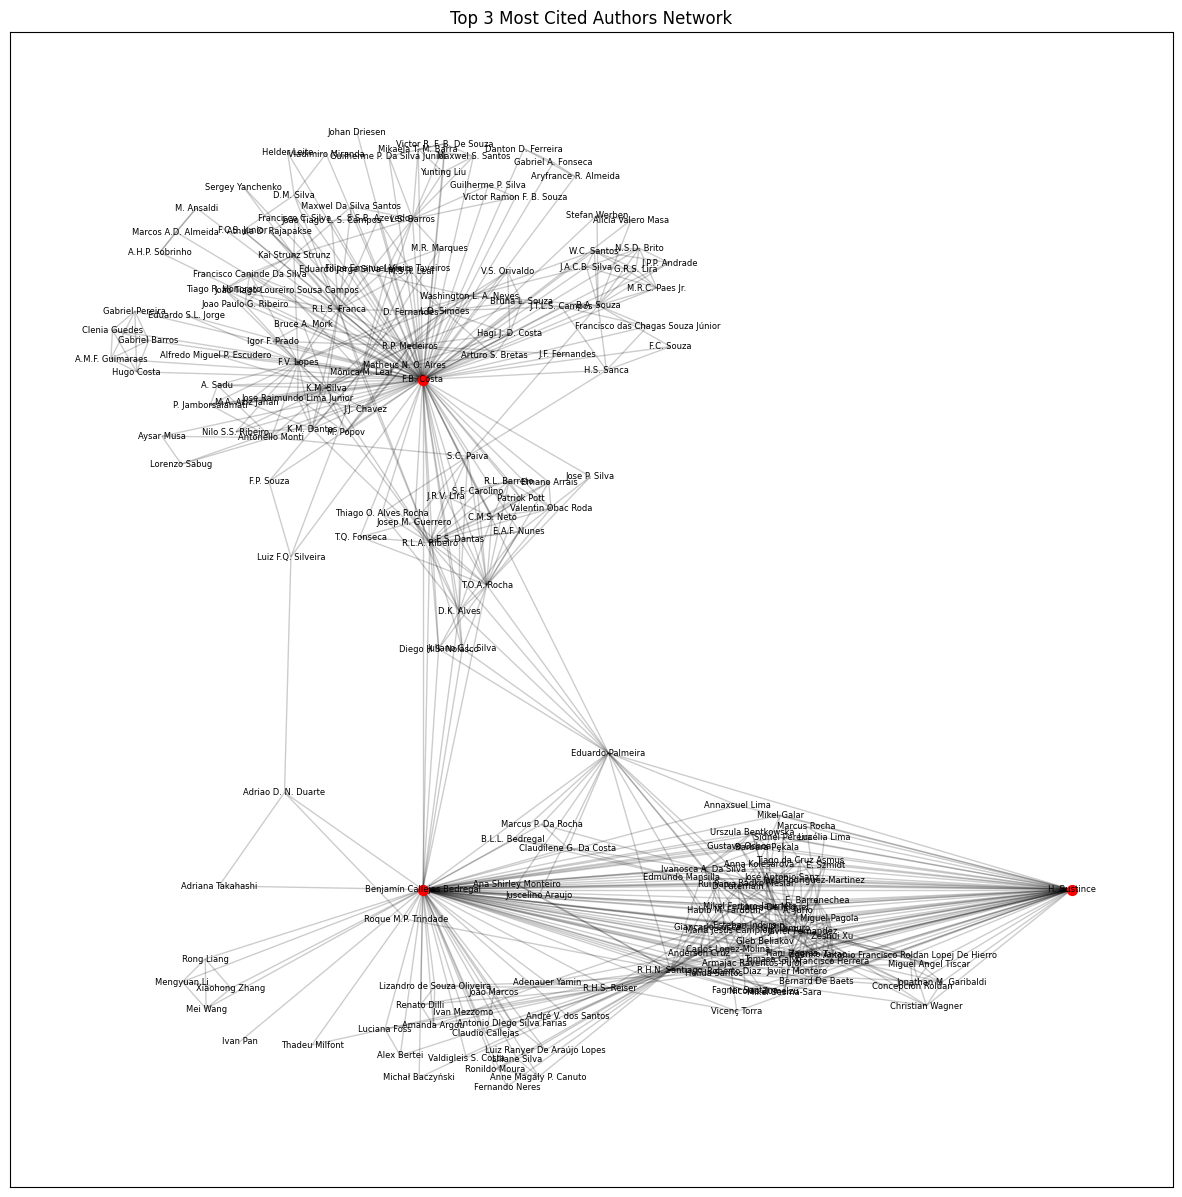

In [65]:
pos = nx.spring_layout(C, fixed=most_cited[:TOP_NODES], pos=initial_pos)
labels = nx.get_node_attributes(C, 'name')

plt.figure(1, figsize=(15, 15))
plt.title(f"Top {TOP_NODES} Most Cited Authors Network")
nx.draw_networkx_nodes(C, pos, node_size=50, node_color='red', nodelist=most_cited[:TOP_NODES])
nx.draw_networkx_edges(C, pos, alpha=0.2)
nx.draw_networkx_labels(C, labels= labels, pos=pos, font_size=6)
plt.show()

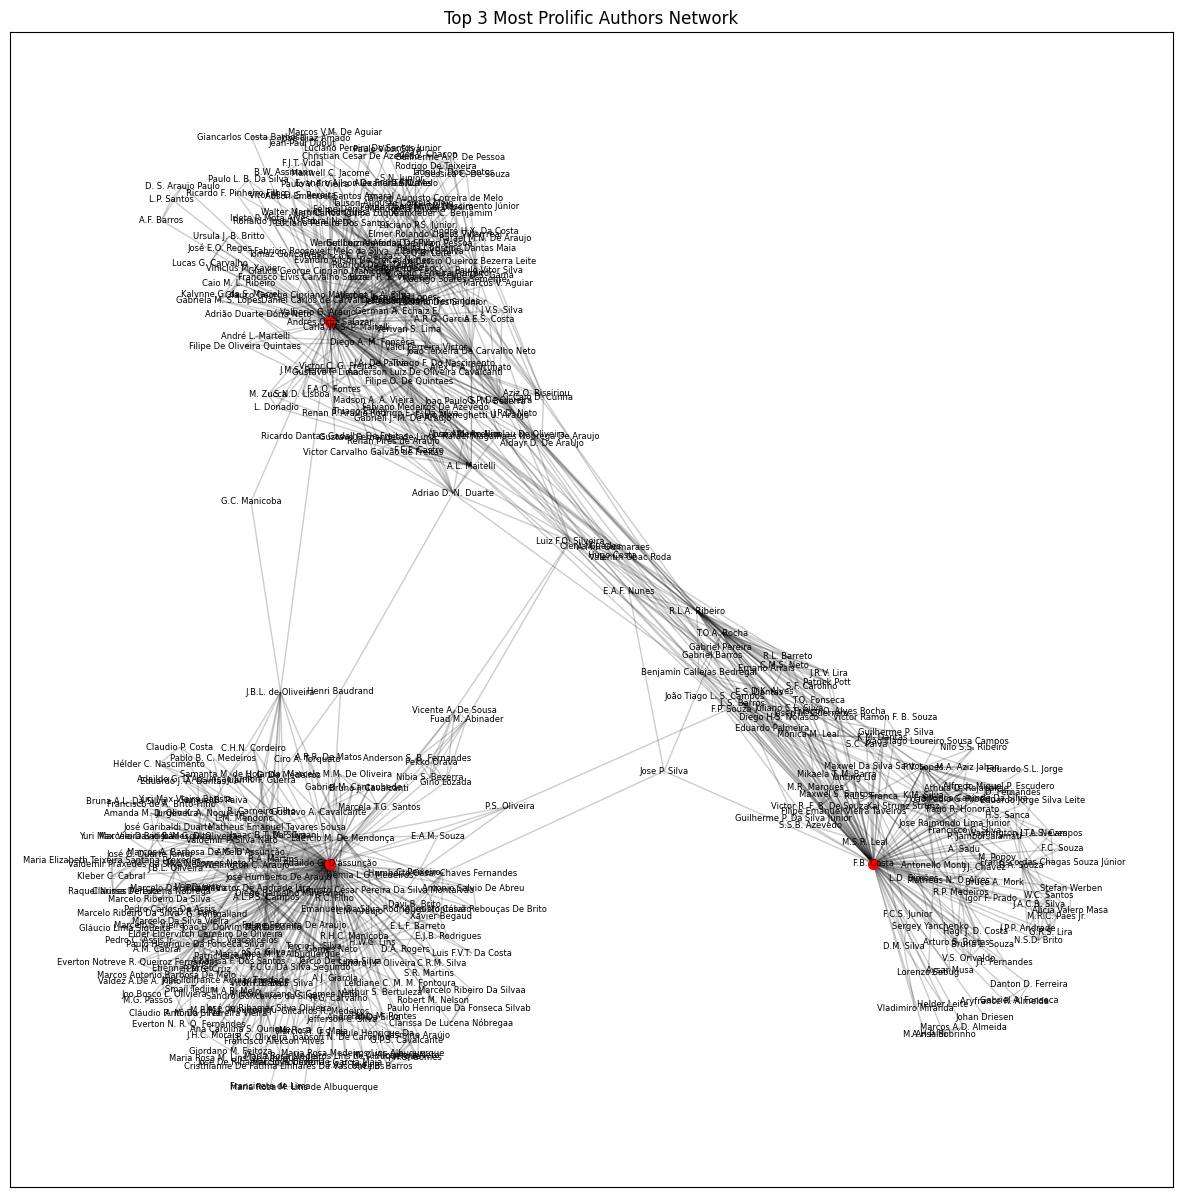

In [66]:
initial_pos = {node : a[i] for i, node in enumerate(most_prolific[:TOP_NODES])}
pos = nx.spring_layout(P, fixed = most_prolific[:TOP_NODES], pos = initial_pos, scale=3)
labels = nx.get_node_attributes(P, 'name')

plt.figure(2, figsize=(15, 15))
plt.title(f"Top {TOP_NODES} Most Prolific Authors Network")
nx.draw_networkx_nodes(P, pos, node_size=50, node_color='red', nodelist=most_prolific[:TOP_NODES])
nx.draw_networkx_edges(P, pos, alpha=0.2)
nx.draw_networkx_labels(P, labels= labels, pos=pos, font_size=6)
plt.show()

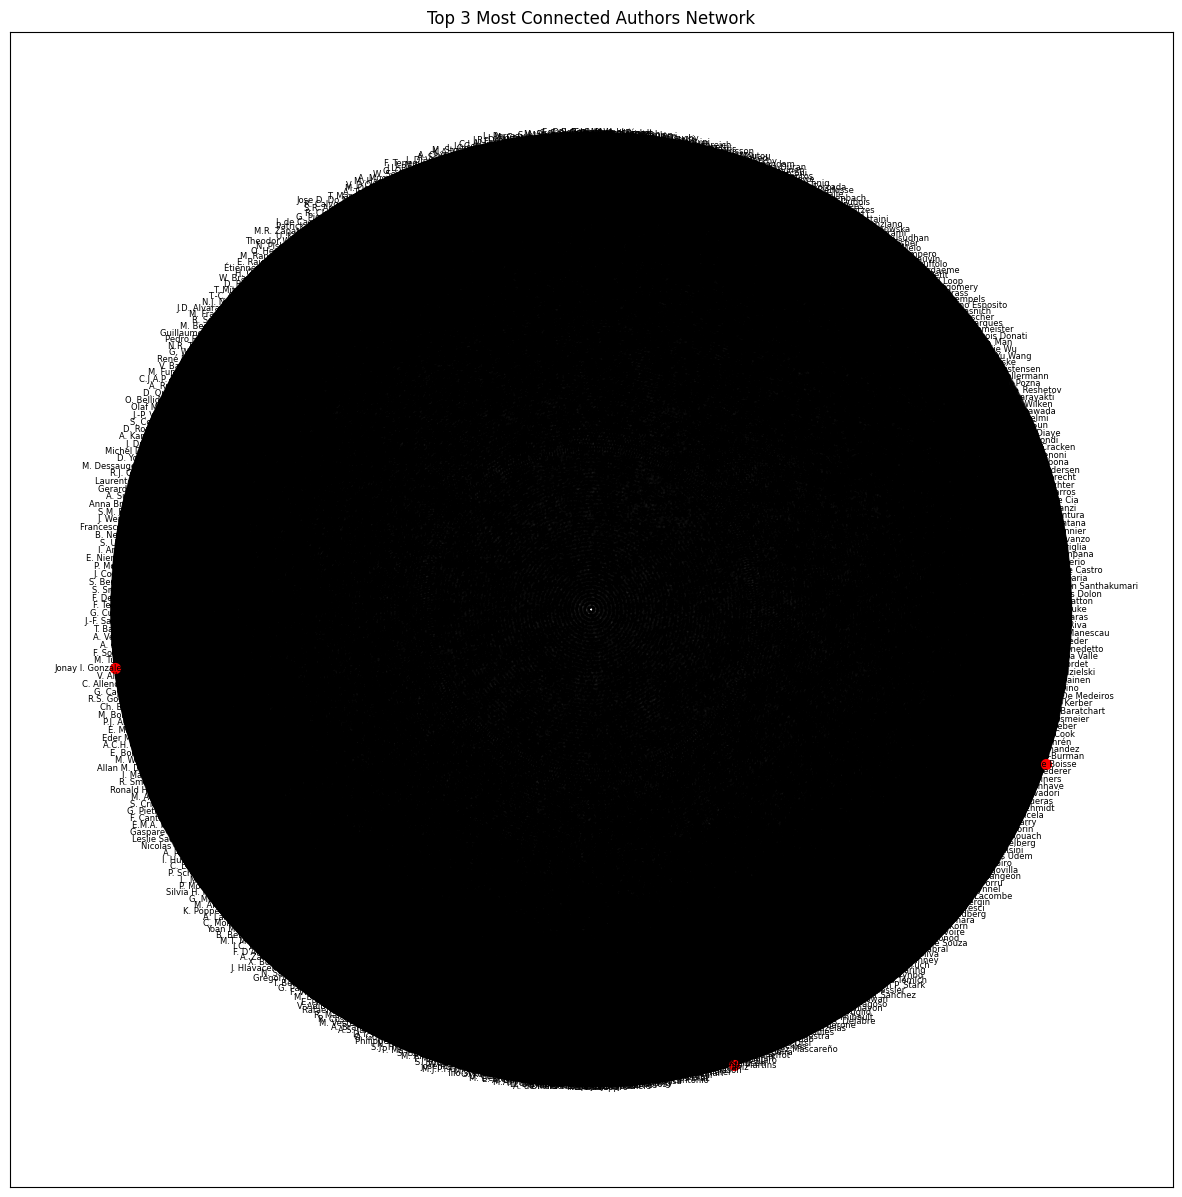

In [71]:
initial_pos = {node : a[i] for i, node in enumerate(most_connected[:TOP_NODES])}
pos = nx.circular_layout(K)
labels = nx.get_node_attributes(K, 'name')

plt.figure(3, figsize=(15, 15))
plt.title(f"Top {TOP_NODES} Most Connected Authors Network")
nx.draw_networkx_nodes(K, pos, node_size=50, node_color='red', nodelist=most_connected[:TOP_NODES])
nx.draw_networkx_edges(K, pos, alpha=0.1)
nx.draw_networkx_labels(K, labels= labels, pos=pos, font_size=6)
plt.show()

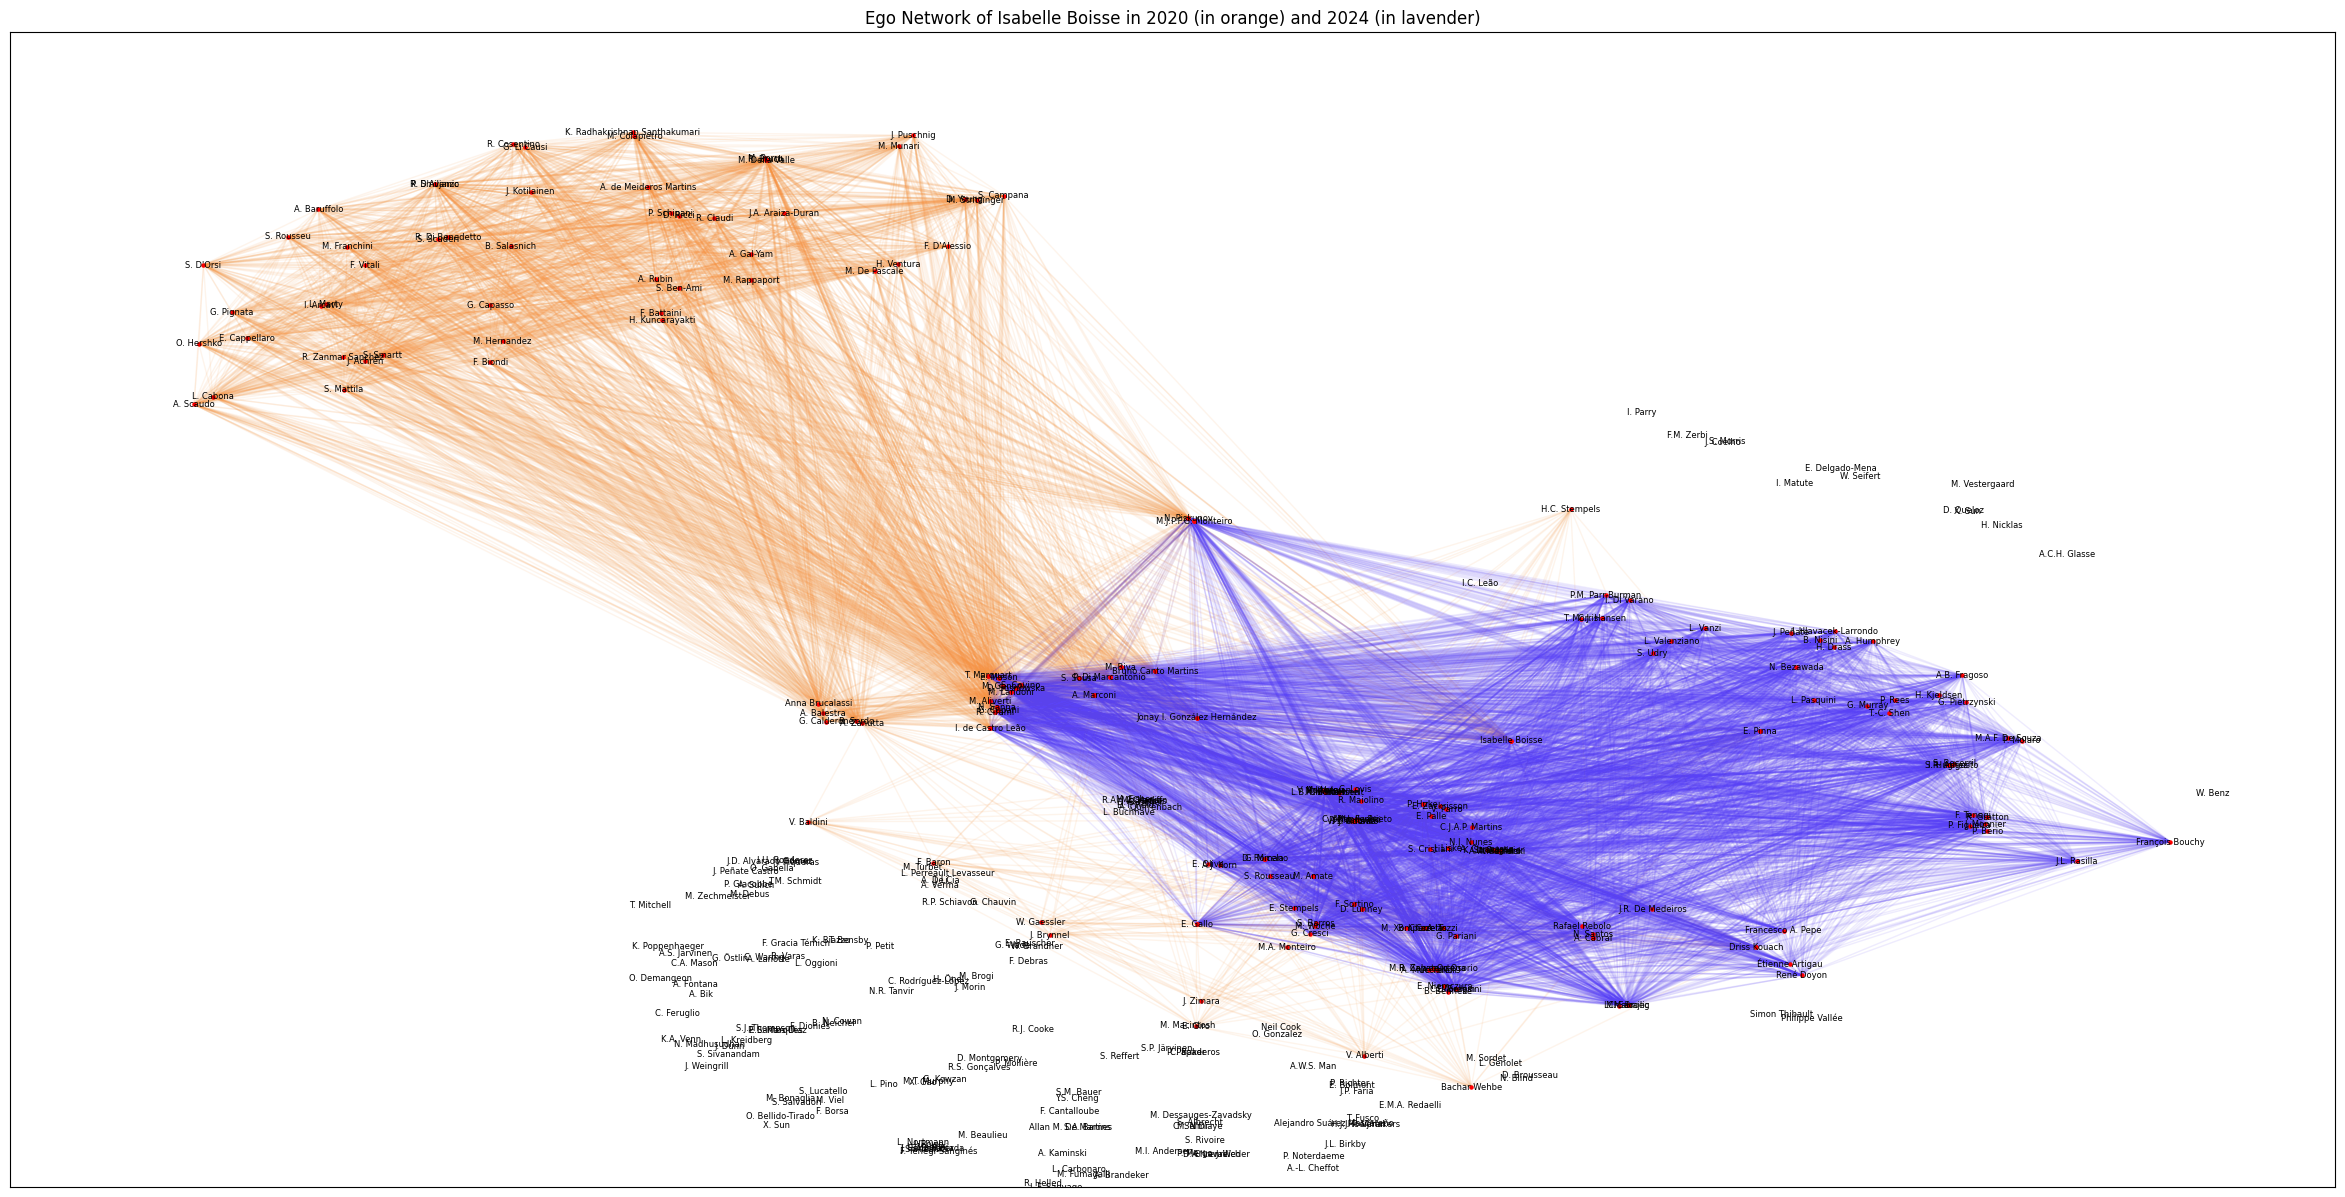

In [72]:
# Create a new graph with the ego network of the most connected author
ego = nx.ego_graph(G, most_connected[0])

# Filter the edges and nodes by year
year = 2024
selected_edges1 = [(u, v) for u, v, e in ego.edges(data=True) if 'year' in e and year in e['year']]
selected_nodes1 = set([node for edge in selected_edges1 for node in edge])
selected_nodes1 = list(selected_nodes1)

year = 2020
selected_edges2 = [(u, v) for u, v, e in ego.edges(data=True) if 'year' in e and year in e['year']]
selected_nodes2 = set([node for edge in selected_edges2 for node in edge])
selected_nodes2 = list(selected_nodes2)

# Create the visualization
pos = nx.spring_layout(ego, seed=522)
labels = nx.get_node_attributes(ego, 'name')

plt.figure(4, figsize=(30, 15))
plt.title(f"Ego Network of {G.nodes[most_connected[0]]['name']} in 2020 (in orange) and 2024 (in lavender)")

nx.draw_networkx_nodes(ego, nodelist=selected_nodes1, pos=pos, node_size=5, node_color='red')
nx.draw_networkx_edges(ego, edgelist=selected_edges1, pos=pos, alpha=0.1, edge_color='#f59542')
 
nx.draw_networkx_nodes(ego, nodelist=selected_nodes2, pos=pos, node_size=5, node_color='red')
nx.draw_networkx_edges(ego, edgelist=selected_edges2, pos=pos, alpha=0.1, edge_color='#5a42f5')
nx.draw_networkx_labels(ego, labels= labels, pos=pos, font_size=6)

plt.show()


As we can see, the first two drawings have a totally different aspect from the one in the third visualization. It shows how dramatic the influence of that 300 or so authors publication is in the co-authorship network for the 3 most connected. Even when we take a look on a single person's (our champion of connections) graph, it is noticeably more dense than the initial visualizations.